**parsing the data and making plots with it**

so far I havent put any fitting on this, its just how I'm getting the data in coutns per second from the ascii files

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit

In [3]:
def file_parser(filename):
    IS_DATA = False

    #the function will fill and return these dictionaries:
    header_dict = {
        "Keys": [],
        "Key Info": []
    }

    spectrum_dict = {
        "bins": [], 
        "counts": []
    }

    with open(filename, "r") as file:
        for line in file:
            line = line.strip()

        # if it's data, reset the flag
            if line == '$DATA:':
                IS_DATA = True
                continue
            elif line.startswith('$'):
                header_dict["Keys"].append(line)
                next_line = next(file).strip()
                header_dict["Key Info"].append(next_line)
                IS_DATA = False

        #this is for all lines following # DATA
        #while IS_DATA == True:  
            if IS_DATA == True:
                try:
                    spectrum_dict["counts"].append(float(line))
                    #w, f = list(map(float, line.split(',')))
                    #spectrum_dict["Wavelength"].append(float(w))
                    #spectrum_dict["Flux"].append(float(f))
                except ValueError:
                    continue   
    #change if bin range changes
    for i in range(1024):
        spectrum_dict["bins"].append(i)
        
    return header_dict, spectrum_dict

In [4]:
header_dict, spectrum_dict = file_parser("experimental_NaI/Am_0degree.Spe")

In [5]:
 spectrum_dict["bins"][-1]

1023

In [6]:
header_dict

{'Keys': ['$SPEC_ID:',
  '$SPEC_REM:',
  '$DATE_MEA:',
  '$MEAS_TIM:',
  '$ROI:',
  '$PRESETS:',
  '$ENER_FIT:',
  '$MCA_CAL:',
  '$SHAPE_CAL:'],
 'Key Info': ['No sample description was entered.',
  'DET# 1',
  '10/21/2025 12:33:31',
  '78 79',
  '0',
  'None',
  '-10.130505 2.230151',
  '3',
  '3']}

In [7]:
len( spectrum_dict["counts"])

1024

In [8]:
spectrum_dict["counts"][1020:]

[0.0, 0.0, 0.0, 0.0]

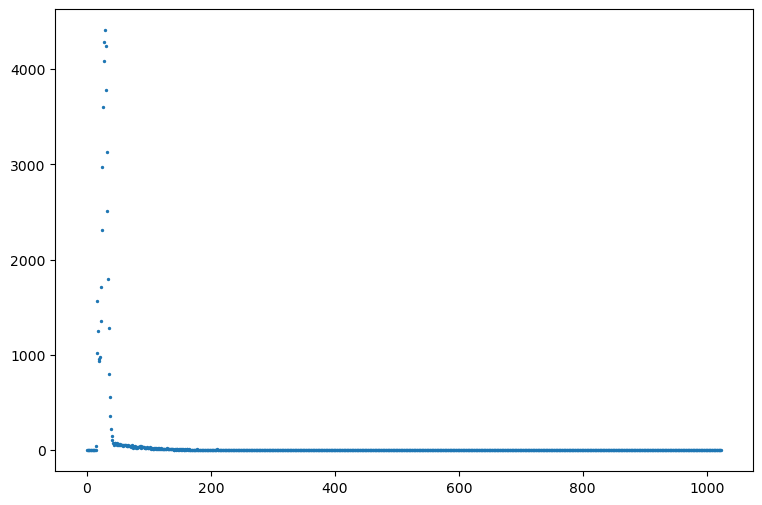

In [9]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(spectrum_dict["bins"], spectrum_dict["counts"], s = 2)

In [10]:
background_header, background_spectrum = file_parser("experimental_NaI/Buffer_Data.Spe")

In [11]:
background_header

{'Keys': ['$SPEC_ID:',
  '$SPEC_REM:',
  '$DATE_MEA:',
  '$MEAS_TIM:',
  '$ROI:',
  '$PRESETS:',
  '$ENER_FIT:',
  '$MCA_CAL:',
  '$SHAPE_CAL:'],
 'Key Info': ['No sample description was entered.',
  'DET# 1',
  '10/21/2025 12:28:00',
  '136 136',
  '0',
  'None',
  '-10.130505 2.230151',
  '3',
  '3']}

In [13]:
#grabbing the count time from the header info

background_counttime = background_header["Key Info"][3].split(" ")
am_counttime = header_dict["Key Info"][3].split(" ")

float(am_counttime[0])

78.0

In [14]:
am_ct = float(am_counttime[0])
background_ct = float(background_counttime[0])

In [15]:
 np.array(background_spectrum["counts"])

array([0., 0., 0., ..., 0., 0., 0.])

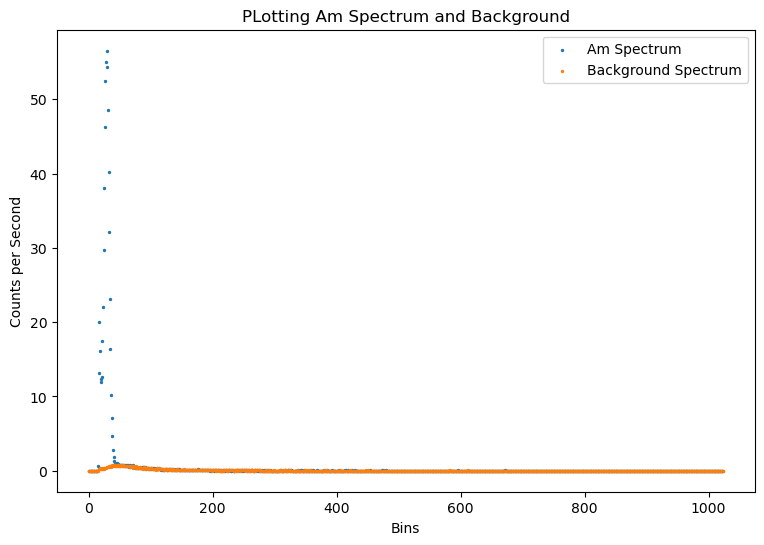

In [16]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Am Spectrum and Background")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"], np.array(spectrum_dict["counts"]) / am_ct, s = 2, label = ("Am Spectrum"))

ax.scatter(background_spectrum["bins"], np.array(background_spectrum["counts"]) / background_ct, s = 2, label = ("Background Spectrum"))
ax.legend()

plt.show()

In [22]:
am_background_subtracted = (np.array(spectrum_dict["counts"]) / am_ct) - ( np.array(background_spectrum["counts"]) / background_ct)

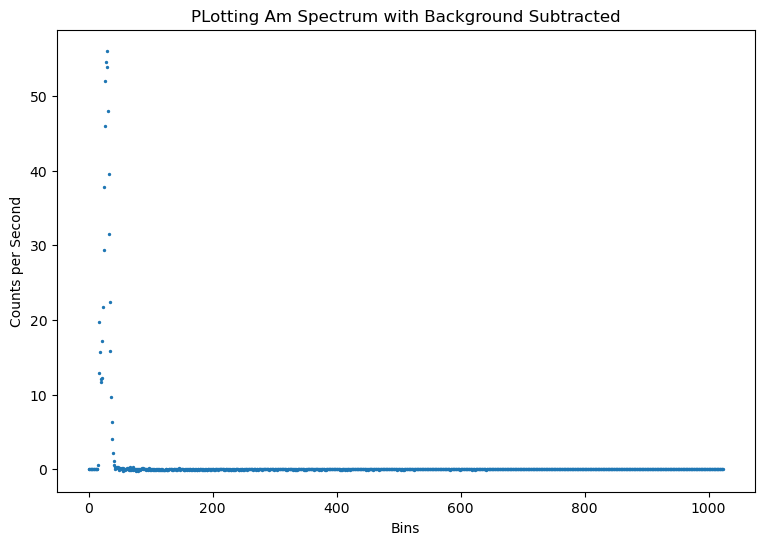

In [23]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Am Spectrum with Background Subtracted")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"], am_background_subtracted, s = 2, label = ("Ba Spectrum background sub"))

plt.show()

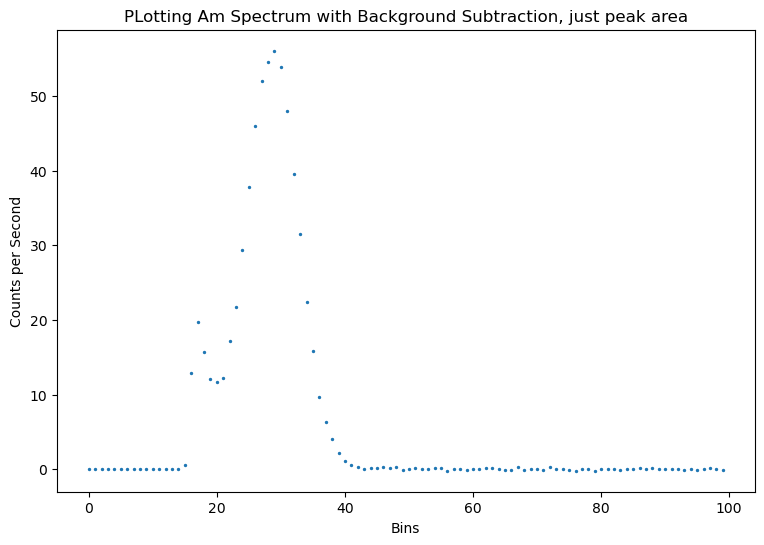

In [24]:
#cutting data to just look at where there are peaks: 

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Am Spectrum with Background Subtraction, just peak area")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"][:100], am_background_subtracted[:100], s = 2, label = ("Am Spectrum background sub"))

plt.show()

In [21]:
# a bunch of gaussing fitting stuff from hw: 
#def ignore_peak(flux):
#    """
 #   Function used to ignore the peak part of the data for plotting the baseline
 #   Input: y data (flux)
#    Output: list of ajdusted y data, were values associated with the peak are replaced with mean flux
  #  """
 #   background_y = []
 #   mean_flux = np.mean(flux)
 #   flux_std = np.std(flux)
 #   for i in flux:
 #       if i > (mean_flux + 2.5 * flux_std): #if the flux is higher than this, the point is probably part of the peak
 #           background_y.append(mean_flux)
  #      else:
#            background_y.append(i)
 #   return background_y
    
#fitting functions: 
def quadratic(x, a, b, c):
    """A quatratic function, used for curve fitting"""
    return a * (x**2) + b * x + c

def gaussian(x, mu, sig, amp):
    """A Gaussian function, used for scipi curve fit"""
    return amp * np.exp(-0.5 * (x-mu)**2 / sig**2) / np.sqrt(2 * np.pi * sig**2)

def compound_model(x, mu, sig, amp, a, b, c):
    """combines the quadratic fit of the background with the Gaussian fit which better represents the peak"""
    return quadratic(x, a, b, c) + gaussian(x, mu, sig, amp)

def fit_compound_model(x, y, p0=None):
    """
    Function to fit data using curve_fit and compound_model
    Inputs: x, y (list of x, y data)
    Outputs: popt (parameters array), pcov (covarience array) 
    """

    #if no p0 is passed, guess: 

    if p0 is None: 
        A_guess = np.max(y) - np.min(y)
        mu_guess = np.sum(x * y) / np.sum(y)
        sigma_guess = (np.max(x) - np.min(x)) / 10
        #getting the polynomial parameters: 
        background_y = ignore_peak(y)
        b_popt, b_pcov = curve_fit(quadratic, x, background_y, p0 = None)

    p0 = [mu_guess, sigma_guess, A_guess, *b_popt]
    popt, pcov = curve_fit(compound_model, x, y, p0 = p0)

    return popt, pcov

def print_uncertainties(pcov, popt):
    """a function to print out the parameters and their uncertanties"""
    uncertainties = np.sqrt(np.diag(pcov))
    #[mu0, sig0, amp0, a, b, c] 
    print("Parameters: \n")
    print(f"Baseline Polynomial Fit: ")
    print(f"a = {popt[3]} +/- {uncertainties[3]},")
    print(f"b = {popt[4]} +/- {uncertainties[4]}, ")
    print(f"c = {popt[5]} +/- {uncertainties[5]}")
    print(f"Gaussian Fit: ")
    print(f"mu0 = {popt[0]} +/- {uncertainties[0]},")
    print(f"sigma0 = {popt[1]} +/- {uncertainties[1]},")
    print(f"amp0 = {popt[2]} +/- {uncertainties[2]}")

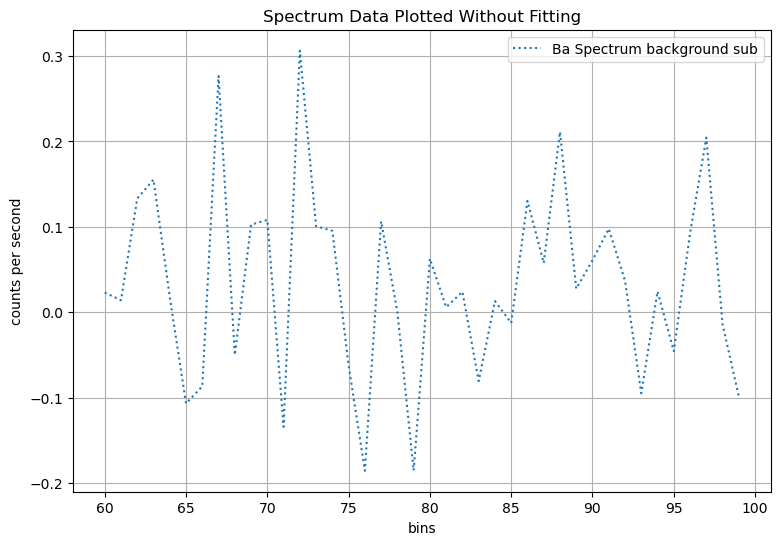

In [38]:
#figuring out how high the counts are for the background here
plt.close("all")
fig, ax = plt.subplots(figsize= (9, 6))
ax.set_title("Spectrum Data Plotted Without Fitting")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(spectrum_dict["bins"][60:100], am_background_subtracted[60:100], ls = ":", label = ("Ba Spectrum background sub"))
ax.grid()
ax.legend()

In [48]:
def ignore_peak(flux):
    """
    Function used to ignore the peak part of the data for plotting the baseline
    Input: y data (flux)
    Output: list of ajdusted y data, were values associated with the peak are replaced with mean flux
    """
    background_y = []
    mean_flux = np.mean(flux)
    flux_std = np.std(flux)
    for i in flux:
        if i > 0.5 :#(mean_flux + 5 * flux_std): #if the flux is higher than this, the point is probably part of the peak
            background_y.append(0)
        else:
            background_y.append(i)
    return background_y

In [49]:
#ignoring the flux for where theres a peak and instead setting the flux value to the mean
background_y = ignore_peak(ba_background_subtracted[:100])
b_popt, b_pcov = curve_fit(quadratic, spectrum_dict["bins"][:100], background_y, p0 = None)
quad_fit = quadratic(np.array(spectrum_dict["bins"][:100]), *b_popt)

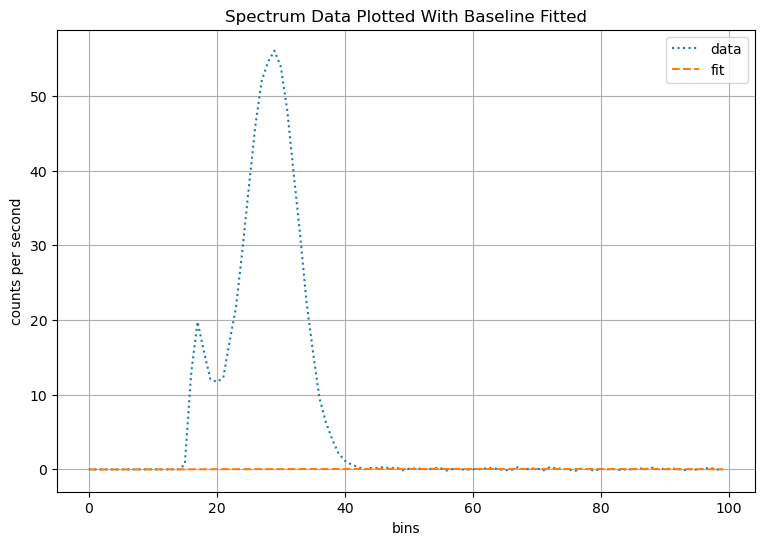

In [50]:
#plotting data with polynomial baseline fit overlaid:
fig, ax = plt.subplots(figsize  = (9,6))
ax.set_title("Spectrum Data Plotted With Baseline Fitted")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(spectrum_dict["bins"][:100], am_background_subtracted[:100], ls = ":", label = "data")
ax.plot(spectrum_dict["bins"][:100], quad_fit, ls = '--', label = "fit")
ax.grid()
ax.legend()

Parameters: 

Baseline Polynomial Fit: 
a = 0.00014669735030938273 +/- 0.000382631192245184,
b = -0.03587455563058666 +/- 0.038236676219448255, 
c = 1.8956537460703553 +/- 0.8339362074909279
Gaussian Fit: 
mu0 = 28.45102355991827 +/- 0.11232435545407882,
sigma0 = -4.282202359290668 +/- 0.1222011657354845,
amp0 = 577.8606843628473 +/- 16.714357318232846


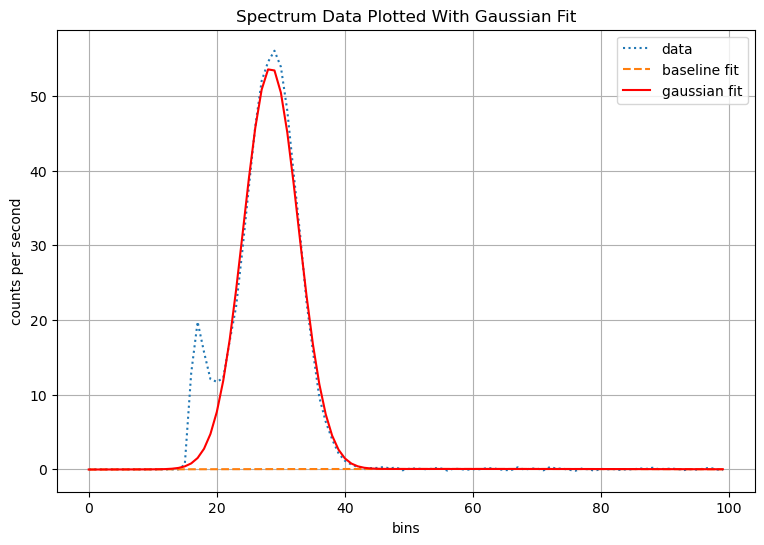

In [51]:
#fitting and plotting gauss model: 
popt, pcov = fit_compound_model(np.array(spectrum_dict["bins"][:100]), np.array(am_background_subtracted[:100]))
gauss_fit = gaussian(np.array(spectrum_dict["bins"][:100]), *popt[:3])
    
fig, ax = plt.subplots(figsize = (9,6))

ax.set_title("Spectrum Data Plotted With Gaussian Fit")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(spectrum_dict["bins"][:100], am_background_subtracted[:100], ls = ":", label = "data")
ax.plot(spectrum_dict["bins"][:100], quad_fit, ls = '--', label = "baseline fit")
#for some reason the line below works better than plotting compound model even though it should return the same thing?
ax.plot(spectrum_dict["bins"][:100], gauss_fit + quad_fit, ls = '-', color = 'r', label = "gaussian fit") 
ax.grid()
ax.legend()

#printing out parameters and uncertainties:
print_uncertainties(pcov, popt)

In [52]:
max_bin = int(popt[0])
max_bin

28

In [53]:
#from looking at https://gammadb.nuclearphoenix.xyz/spectrum/Am-241/ there is also one defined peak for Am
# and it is at 59.91 KeV

In [38]:
peaks_table = {
    'sample' : ['Am'],
    'bin': [28],
    'energy guess (KeV)': [59.91]
}

**Doing same thing with Cs**

In [4]:
header_dict, spectrum_dict = file_parser("experimental_NaI/Cs_0degree.Spe")

In [5]:
header_dict

{'Keys': ['$SPEC_ID:',
  '$SPEC_REM:',
  '$DATE_MEA:',
  '$MEAS_TIM:',
  '$ROI:',
  '$PRESETS:',
  '$ENER_FIT:',
  '$MCA_CAL:',
  '$SHAPE_CAL:'],
 'Key Info': ['No sample description was entered.',
  'DET# 1',
  '10/21/2025 12:17:17',
  '73 73',
  '0',
  'None',
  '-10.130505 2.230151',
  '3',
  '3']}

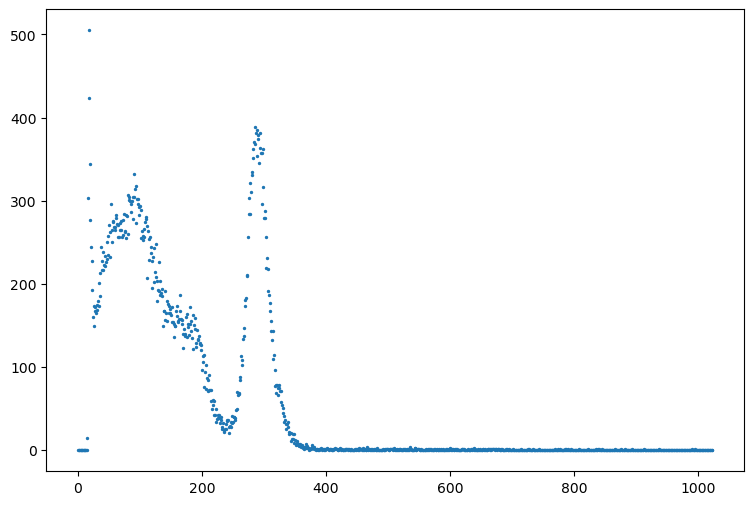

In [9]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(spectrum_dict["bins"], spectrum_dict["counts"], s = 2)

In [46]:
#grabbing the count time from the header info
background_header, background_spectrum = file_parser("experimental_NaI/Buffer_Data.Spe")

background_counttime = background_header["Key Info"][3].split(" ")
data_counttime = header_dict["Key Info"][3].split(" ")

data_ct = float(data_counttime[0])
background_ct = float(background_counttime[0])


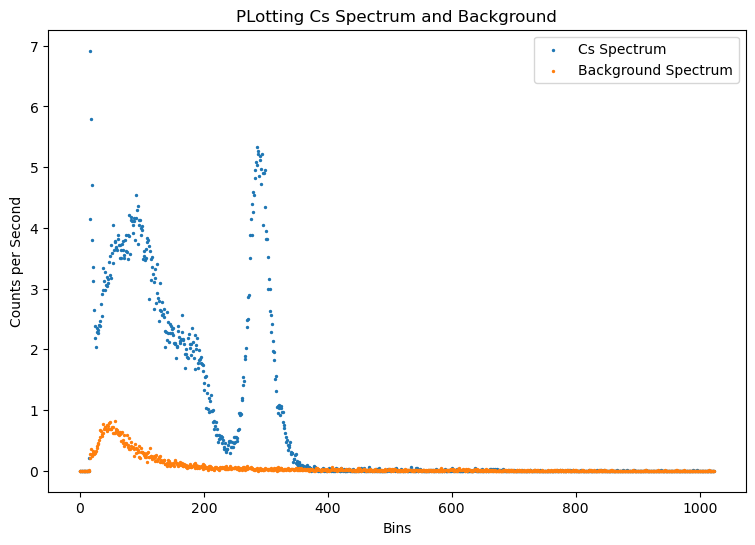

In [47]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Cs Spectrum and Background")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"], np.array(spectrum_dict["counts"]) / data_ct, s = 2, label = ("Cs Spectrum"))

ax.scatter(background_spectrum["bins"], np.array(background_spectrum["counts"]) / background_ct, s = 2, label = ("Background Spectrum"))
ax.legend()

plt.show()

In [48]:
data_background_subtracted = (np.array(spectrum_dict["counts"]) / data_ct) - ( np.array(background_spectrum["counts"]) / background_ct)

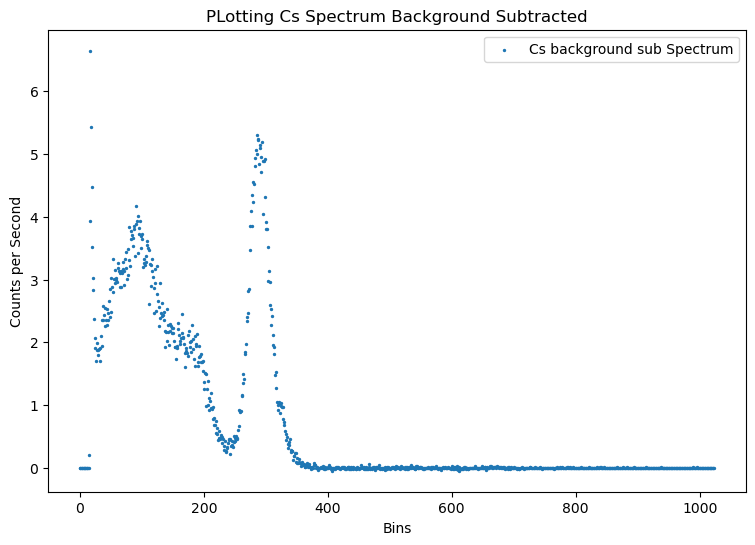

In [49]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Cs Spectrum Background Subtracted")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"], data_background_subtracted, s = 2, label = ("Cs background sub Spectrum"))

ax.legend()

plt.show()

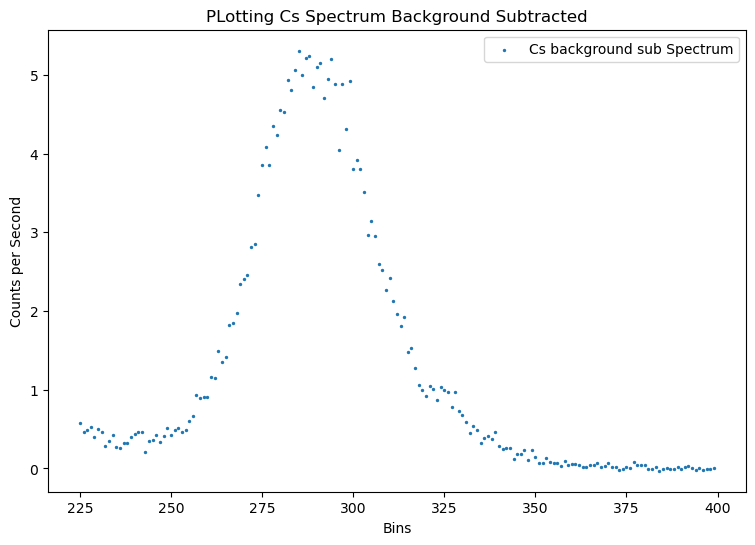

In [50]:
#theres a peak between 200-400 bins: 

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Cs Spectrum Background Subtracted")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"][225:400], data_background_subtracted[225:400], s = 2, label = ("Cs background sub Spectrum"))

ax.legend()

plt.show()

In [51]:
def ignore_peak(flux):
    """
    Function used to ignore the peak part of the data for plotting the baseline
    Input: y data (flux)
    Output: list of ajdusted y data, were values associated with the peak are replaced with mean flux
    """
    background_y = []
    mean_flux = np.mean(flux)
    flux_std = np.std(flux)
    for i in flux:
        if i > 0.5 :#(mean_flux + 5 * flux_std): #if the flux is higher than this, the point is probably part of the peak
            background_y.append(0)
        else:
            background_y.append(i)
    return background_y

In [52]:
background_y = ignore_peak(data_background_subtracted[225:400])
b_popt, b_pcov = curve_fit(quadratic, spectrum_dict["bins"][225:400], background_y, p0 = None)
quad_fit = quadratic(np.array(spectrum_dict["bins"][225:400]), *b_popt)

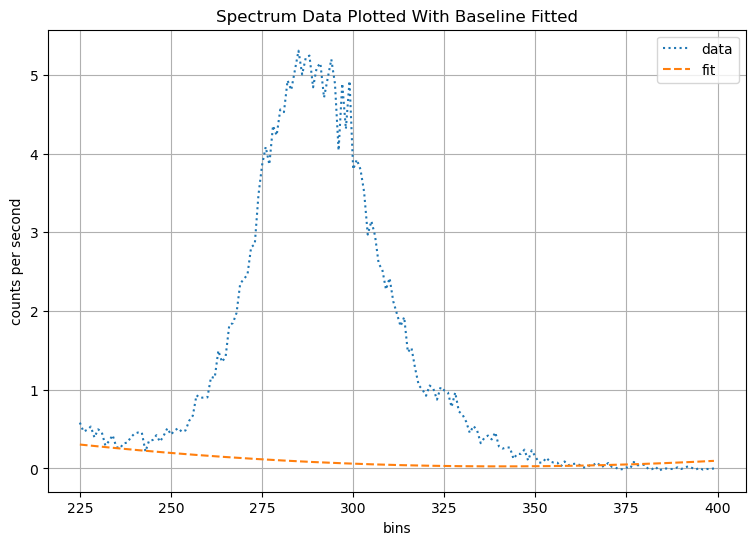

In [53]:
#plotting data with polynomial baseline fit overlaid:
fig, ax = plt.subplots(figsize  = (9,6))
ax.set_title("Spectrum Data Plotted With Baseline Fitted")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(spectrum_dict["bins"][225:400], data_background_subtracted[225:400], ls = ":", label = "data")
ax.plot(spectrum_dict["bins"][225:400], quad_fit, ls = '--', label = "fit")
ax.grid()
ax.legend()

Parameters: 

Baseline Polynomial Fit: 
a = -3.782258907696527e-05 +/- 7.925134663055749e-06,
b = 0.02118230856896329 +/- 0.00486358128460845, 
c = -2.5512142834131706 +/- 0.717918456359323
Gaussian Fit: 
mu0 = 289.3165355027151 +/- 0.15659291474377587,
sigma0 = -15.059988244239605 +/- 0.1986870882720849,
amp0 = 180.72608674632966 +/- 3.0891847402346415


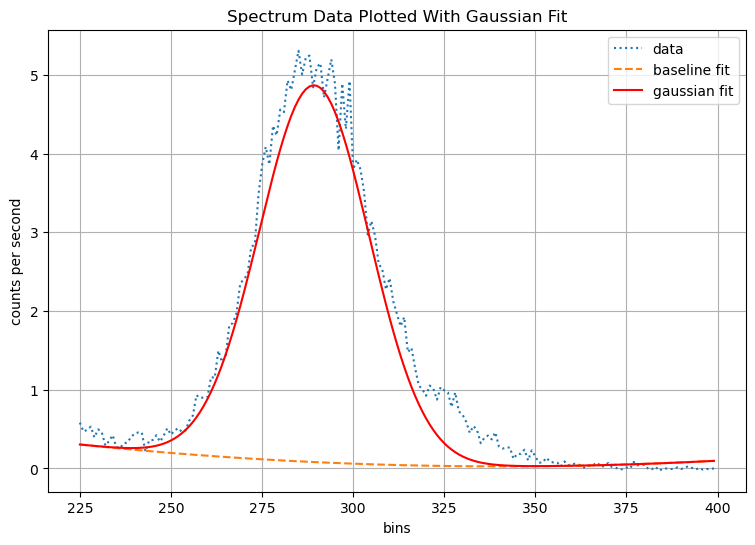

In [54]:
#fitting and plotting gauss model: 
popt, pcov = fit_compound_model(np.array(spectrum_dict["bins"][225:400]), np.array(data_background_subtracted[225:400]))
gauss_fit = gaussian(np.array(spectrum_dict["bins"][225:400]), *popt[:3])
    
fig, ax = plt.subplots(figsize = (9,6))

ax.set_title("Spectrum Data Plotted With Gaussian Fit")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(spectrum_dict["bins"][225:400], data_background_subtracted[225:400], ls = ":", label = "data")
ax.plot(spectrum_dict["bins"][225:400], quad_fit, ls = '--', label = "baseline fit")
#for some reason the line below works better than plotting compound model even though it should return the same thing?
ax.plot(spectrum_dict["bins"][225:400], gauss_fit + quad_fit, ls = '-', color = 'r', label = "gaussian fit") 
ax.grid()
ax.legend()

#printing out parameters and uncertainties:
print_uncertainties(pcov, popt)

In [55]:
max_bin = int(popt[0])
max_bin

289

In [30]:
#this is maybe the peak at 622.69 keV? 

In [39]:
peaks_table['sample'].append('Cs')
peaks_table['bin'].append(289)
peaks_table['energy guess (KeV)'].append(622.69)

In [40]:
peaks_table

{'sample': ['Am', 'Cs'],
 'bin': [28, 289],
 'energy guess (KeV)': [59.91, 622.69]}

In [41]:
#from the Barium notebook and a guess from the website of peaks: 
peaks_table['sample'].append('Ba133')
peaks_table['bin'].append(38)
peaks_table['energy guess (KeV)'].append(80.46)

In [42]:
peaks_table

{'sample': ['Am', 'Cs', 'Ba133'],
 'bin': [28, 289, 38],
 'energy guess (KeV)': [59.91, 622.69, 80.46]}

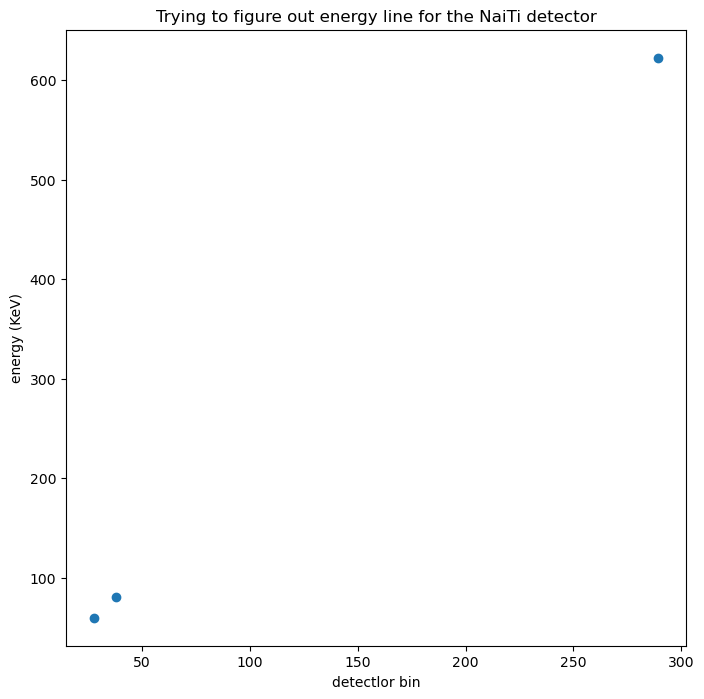

In [43]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_title("Trying to figure out energy line for the NaiTi detector")
ax.set_xlabel("detectlor bin")
ax.set_ylabel("energy (KeV)")

ax.scatter(peaks_table['bin'], peaks_table['energy guess (KeV)'])

In [66]:
from lmfit.models import LinearModel

line = LinearModel()

def model_fit_and_plot(xdata, ydata, title, model=LinearModel()):
    '''
    Fit a line or curve, and plot/show the fit results.
    The function returns a parameters object with the fit parameters
    '''
    params = model.make_params()
    model_fit = model.fit(ydata, params, x=xdata)
    model_fit.plot()
    plt.title(f'Fitting a line to {title}')
    plt.ylabel("Detector Bin")
    plt.xlabel("Peak Energy (KeV)")
    plt.scatter(xdata, ydata, marker = '.', label = 'Data')
    plt.legend()
    print(model_fit.fit_report())
    # Complete the function
    return model_fit.params

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 3
    # variables        = 2
    chi-square         = 0.53213686
    reduced chi-square = 0.53213686
    Akaike info crit   = -1.18840059
    Bayesian info crit = -2.99117601
    R-squared          = 0.99999739
[[Variables]]
    slope:      2.15810466 +/- 0.00348794 (0.16%) (init = 1)
    intercept: -1.02238504 +/- 0.58968879 (57.68%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.6999


name,value,standard error,relative error,initial value,min,max,vary
slope,2.15810466,0.00348794,(0.16%),1.0,-inf,inf,True
intercept,-1.02238504,0.58968879,(57.68%),0.0,-inf,inf,True


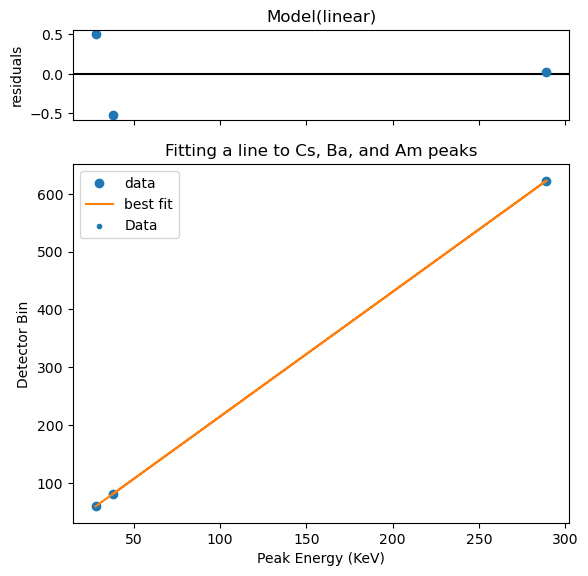

In [67]:
model_fit_and_plot(peaks_table['bin'], peaks_table['energy guess (KeV)'], "Cs, Ba, and Am peaks")

**this looks like its working (energy is a staright line ish) so now I'm gonna to the Co sample**

In [57]:
header_dict, spectrum_dict = file_parser("experimental_NaI/Co_0degree.Spe")

background_header, background_spectrum = file_parser("experimental_NaI/Buffer_Data.Spe")

background_counttime = background_header["Key Info"][3].split(" ")
data_counttime = header_dict["Key Info"][3].split(" ")

data_ct = float(data_counttime[0])
background_ct = float(background_counttime[0])

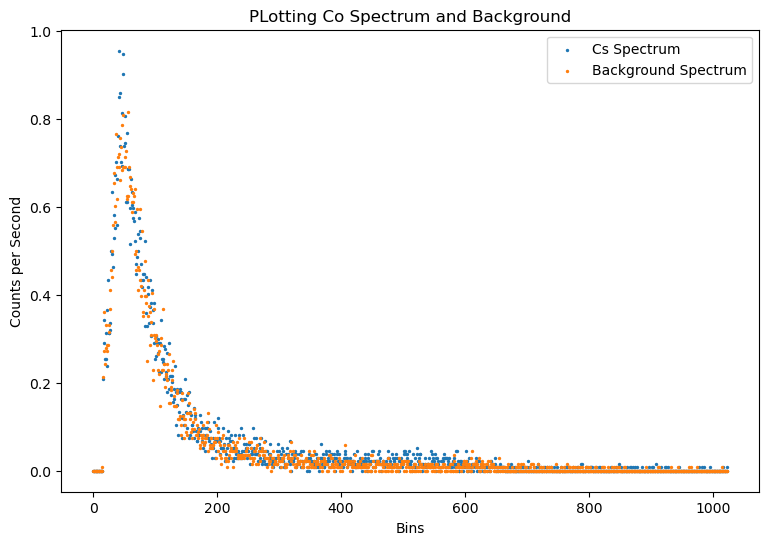

In [59]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Co Spectrum and Background")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"], np.array(spectrum_dict["counts"]) / data_ct, s = 2, label = ("Cs Spectrum"))

ax.scatter(background_spectrum["bins"], np.array(background_spectrum["counts"]) / background_ct, s = 2, label = ("Background Spectrum"))
ax.legend()

plt.show()

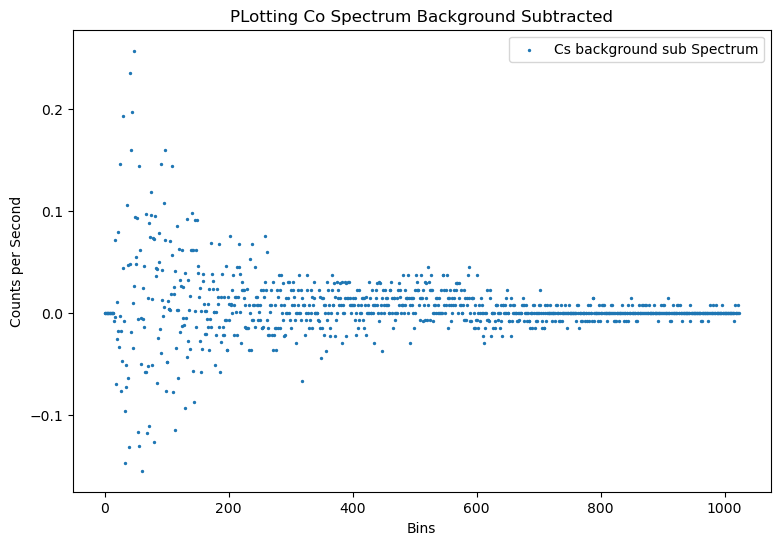

In [61]:
data_background_subtracted = (np.array(spectrum_dict["counts"]) / data_ct) - ( np.array(background_spectrum["counts"]) / background_ct)

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Co Spectrum Background Subtracted")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"], data_background_subtracted, s = 2, label = ("Cs background sub Spectrum"))

ax.legend()

plt.show()

In [62]:
#cobalt sucks, gonna do energy fit with just the three